<a href="https://colab.research.google.com/github/karlmaji/pytorch_UNet/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基于VGG16的UNet 模型搭建
## Unet基本模型如下图所示 红色为 提取5个feature map 的shape 
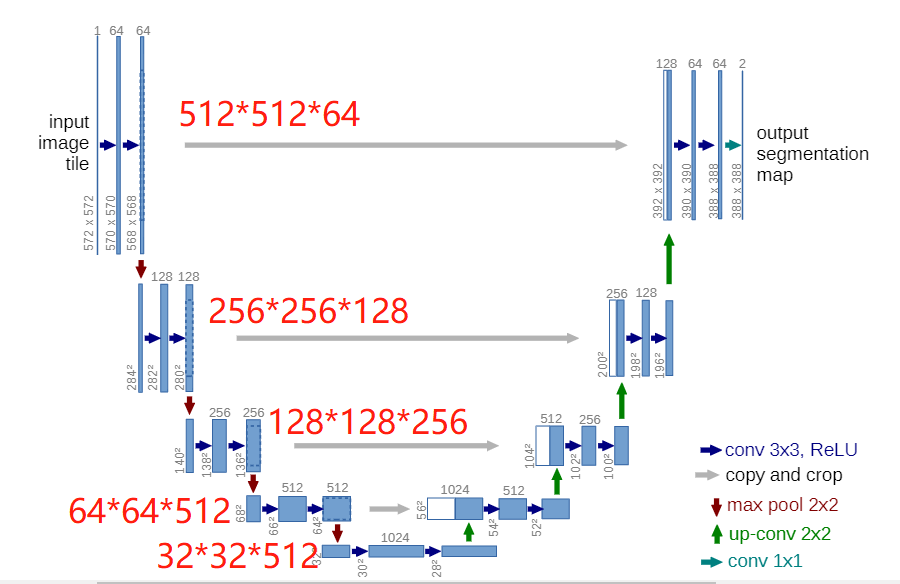

In [ ]:
import torch
torch.__version__

In [ ]:
import torchvision
torchvision.__version__

In [ ]:
!pip install einops

In [ ]:
!pip install pytorch_lightning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50,vgg16
from torchvision.models import feature_extraction as Fe
from einops import rearrange,reduce,repeat
import pytorch_lightning as pl
from torch.utils.data import Dataset,DataLoader
import numpy as np
from PIL import Image
import os
import torchvision.transforms as T
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)


# 训练数据集采用VOC2007


In [ ]:
"""
## train_txt_path 包含训练集图片的id
## val_txt_path 包含验证集图片的id
## Img_Path 数据图片地址
## Label_Path 标签图片所在地址
"""
train_txt_path = 'F:/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt'
val_txt_path = 'F:/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt'
Img_Path = 'F:/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
Label_Path = 'F:/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass/'


In [ ]:
"""
VOC数据集 类别、每一类在Label图片中的像素值
"""
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

#创建色彩分布与标签表供查询
cm2lbl = torch.zeros(256,256,256)
for i, cm in enumerate(colormap):
    cm2lbl[cm[0],cm[1],cm[2]] = i

In [ ]:
"""
构建dataset
"""
class SegDataSet(Dataset):
    def __init__(self, Img_Path, Label_Path, ID_Path, img_transforms, label_transforms):
        super(SegDataSet,self).__init__()
        self.Img_Path = Img_Path
        self.img_transforms = img_transforms
        self.label_transforms = label_transforms
        self.Label_Path = Label_Path
        self.ID_List = []
        with open(ID_Path,'r') as f:
            for line in f.readlines():
                self.ID_List.append(line.strip())
            
    def __len__(self):
        return len(self.ID_List)
    def __getitem__(self,idx):
        img = Image.open(os.path.join(self.Img_Path , self.ID_List[idx] + '.jpg')).convert('RGB')
        Label = Image.open(os.path.join(self.Label_Path , self.ID_List[idx] + '.png')).convert('RGB')
        img , Label =  self.img_transforms(img) , self.label_transforms(Label)
        return img , Label

"""
将图片的大小填充成：模型输入的尺寸（3,512,512）
"""    
def padding_func(x , wh=(512,512)):
    c,h,w = x.shape
    target_h , target_w = wh
    pad_h = int((target_h - h) / 2)
    pad_w = int((target_w - w) / 2)
    x = F.pad(x,(pad_w,(target_w - w) - pad_w ,pad_h ,(target_h - h) - pad_h) , mode='constant', value=0.0 )
    return x

# 将label_img 转换为 Label
# input shape [c , h , w]
# output shape [h w]
def labelimg_to_label(x):
    x =x.long()
    x = cm2lbl[x[0],x[1],x[2]].to(torch.int64)
    return x

    
# 训练图片的预处理
img_transforms = T.Compose([
    #T.RandomAffine(10),
    #T.RandomHorizontalFlip(0.3),
    #T.RandomPerspective()
    T.PILToTensor(), #将PIL图片转为Tensor类型
    T.ConvertImageDtype(torch.float), #将uint8 数据格式转为float
    T.Lambda(padding_func), #对tensor做填充
    #数据归一化均值方差来自于ImageNet数据集 是VGG预训练模型的归一化值
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
])
# Label图片的预处理
Label_transforms =  T.Compose([
    T.PILToTensor(),
    T.Lambda(padding_func), 
    T.Lambda(labelimg_to_label)
])
#实例化dataset
train_dataset = SegDataSet(
    Img_Path = Img_Path,
    Label_Path = Label_Path,
    ID_Path = train_txt_path,
    img_transforms = img_transforms,
    label_transforms = Label_transforms)

val_dataset = SegDataSet(
    Img_Path = Img_Path,
    Label_Path = Label_Path,
    ID_Path = val_txt_path,
    img_transforms = img_transforms,
    label_transforms = Label_transforms)

#构建dataloader  实际训练时可以添加参数 num_workers 采用多线程读入dataset
train_dataloader = DataLoader(train_dataset,batch_size = 4,shuffle = True)
val_dataloader = DataLoader(val_dataset,batch_size = 4,shuffle = False)

# img , label = next(iter(val_dataloader))
# print(img.shape , label.shape)
# label.max()

In [ ]:
"""
打印出vgg16的结构 和对应层的节点名
"""
# model = vgg16()
# train_node,eval_node  = Fe.get_graph_node_names(model)
# print(train_node)
# print(model)

In [ ]:
"""
构建预训练好的vgg模型 并抽取需要的featuremap
"""
class Vgg(nn.Module):
    def __init__(self):
        super(Vgg,self).__init__()
        vgg_ = vgg16(pretrained =True)
        """
        'features.3 'features.8' 等名称来自于上个代码块中的train_node
        """
        return_node = {
            'features.3':'feature1',
            'features.8':'feature2',
            'features.15':'feature3',
            'features.22':'feature4',
            'features.29':'feature5',}
        #使用create_feature_extractor函数从模型中抽取特征图
        self.feature_node = Fe.create_feature_extractor(vgg_,return_node)
        # 冻结网络参数
        self._forze()
        
    def forward(self,x):
        # return a dict for features
        # 前向运算将返回一个类似{'feature1':tensor1,'feature2',tensor2,.....}的列表
        return self.feature_node(x)
    def _forze(self):
        for parameters in self.feature_node.parameters():
            parameters.require_grad  =False

"""
#Test:

model = Vgg()
x = torch.randn(1,3,512,512)
for named,feature in model(x).items():
    print(feature.shape)
    
#output

# torch.Size([1, 64, 512, 512])
# torch.Size([1, 128, 256, 256])
# torch.Size([1, 256, 128, 128])
# torch.Size([1, 512, 64, 64])
# torch.Size([1, 512, 32, 32])
"""

In [ ]:
#构建上采样网络模块
class Unet_upsample(nn.Module):
    def __init__(self,input_size,output_size):
        super(Unet_upsample,self).__init__()
        self.upsample = nn.Upsample(scale_factor = 2)
        self.conv1 = nn.Conv2d(in_channels = input_size,out_channels = output_size , kernel_size = 3 ,padding='same')
        self.conv2 = nn.Conv2d(in_channels = output_size,out_channels = output_size ,kernel_size = 3 ,padding='same')
        self.relu = nn.ReLU(inplace=True)
    def forward(self,small_F,large_F):
        small_F = self.upsample(small_F)
        x = torch.concat((small_F,large_F),dim = 1) #在通道维度上进行拼接
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x
    

"""    
#test
up1 = Unet_upsample(1024,512)
x1 = torch.randn(1,512,32,32)
x2 = torch.randn(1,512,64,64)
print(up1(x1,x2).shape)

#output

#torch.Size([1, 512, 64, 64])

 
"""

In [ ]:
"""
#构建pytorch_Lightning模型
#这里损失函数简单的使用了交叉熵 效果不是很好，可以更好其他的
"""
class UnetLightning(pl.LightningModule):
    def __init__(self,num_class = 21):
        super(UnetLightning,self).__init__()
        self.vgg = Vgg()
        self.up1 = Unet_upsample(1024,512)
        self.up2 = Unet_upsample(768,256) # 512 to concat 256
        self.up3 = Unet_upsample(384,128) # 256 to concat 128
        self.up4 = Unet_upsample(192,64) # 128 to concat 64
        self.final = nn.Conv2d(64 , num_class , kernel_size = 1)
        
    def forward(self,x):
        feature_dic = self.vgg(x)
        x = self.up1(feature_dic["feature5"],feature_dic["feature4"])
        
        x = self.up2(x , feature_dic["feature3"] )
        x = self.up3(x , feature_dic["feature2"] )
        x = self.up4(x , feature_dic["feature1"] )
        x = self.final(x)
        return x
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters() , lr = 1e-3)
    def training_step(self,batch,batch_idx):
        x , y = batch
        y = y.squeeze()
        logits = self(x)
        loss = F.cross_entropy(logits , y)
        self.log("train_loss",loss)
        return loss
    def validation_step(self,batch,batch_idx):
        x , y = batch
        y = y.squeeze()
        logits = self(x)
        val_loss = F.cross_entropy(logits , y)
        self.log("val_loss",val_loss)
        return val_loss
    
    


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpointCallback = ModelCheckpoint(dirpath='./',
                                     filename='{epoch}-{val_loss:.7f}-{train_loss:.7f}',
                                    monitor='val_loss',
                                    save_top_k = 4)
model = UnetLightning(num_class = 21)
trainer = pl.Trainer(gpus=1,callbacks = [checkpointCallback],check_val_every_n_epoch = 5 )
trainer.fit(model,train_dataloader,val_dataloader)

In [ ]:
# model = UnetLightning(num_class = 21)
# model.load_from_checkpoint("epoch=47-val_loss=0.7976160-train_loss=0.7876524.ckpt" , num_class =21)


In [ ]:
"""
模型预测部分

"""

img_path ="F:/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000033.jpg"
img = Image.open(img_path).convert('RGB')

img_transforms = T.Compose([
    #T.RandomAffine(10),
    #T.RandomHorizontalFlip(0.3),
    #T.RandomPerspective()
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    T.Lambda(padding_func),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
pred_transforms = T.Compose([
    #T.RandomAffine(10),
    #T.RandomHorizontalFlip(0.3),
    #T.RandomPerspective()
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    T.Lambda(padding_func),
    T.ConvertImageDtype(torch.uint8)
    #T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

img

In [ ]:
from torchvision.utils import draw_segmentation_masks

def predict(model,img,predict_transforms,transforms):
    img_data = predict_transforms(img)
    img_data = rearrange(img_data , 'c h w -> 1 c h w')
    model.eval()
    #logits = model(img_data)["out"]
    logits = model(img_data)
    #print(logits.shape)
    logits = F.softmax(logits,1).argmax(1)
    mask = torch.zeros(21,512,512).to(torch.bool)
    for i in range(21):
        mask[i,:,:] = logits == i
    #print(mask.shape)
#     #print(mask)
#     #print(logits.shape)
#     #print(logits.max())
#     #print(logits)
    img = transforms(img)
    #print(img.shape)
    img = draw_segmentation_masks(img,mask,alpha  = 0.8)
    return img


show = T.ToPILImage()
img_data = predict(model,img,img_transforms,pred_transforms)
show(img_data)

# 虽然能够复现出模型，但是训练效果并不是很好
# 下面是使用pytorch中提供的FCN_resnet50 做预测的效果

In [ ]:
from torchvision.models.segmentation import fcn_resnet50
model = fcn_resnet50(pretrained = True)
print(model)

In [ ]:
from torchvision.utils import draw_segmentation_masks

def predict(model,img,predict_transforms,transforms):
    img_data = predict_transforms(img)
    img_data = rearrange(img_data , 'c h w -> 1 c h w')
    model.eval()
    logits = model(img_data)["out"]
    #logits = model(img_data)
    print(logits.shape)
    logits = F.softmax(logits,1).argmax(1)
    mask = torch.zeros(21,512,512).to(torch.bool)
    for i in range(21):
        mask[i,:,:] = logits == i
    #print(mask.shape)
#     #print(mask)
#     #print(logits.shape)
#     #print(logits.max())
#     #print(logits)
    img = transforms(img)
    #print(img.shape)
    img = draw_segmentation_masks(img,mask,alpha  = 0.8)
    return img


show = T.ToPILImage()
img_data = predict(model,img,img_transforms,pred_transforms)
show(img_data)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpointCallback = ModelCheckpoint(dirpath='./',
                                     filename='{epoch}-{val_loss:.7f}-{train_loss:.7f}',
                                    monitor='val_loss',
                                    save_top_k = 4)
model = UnetLightning(num_class = 21)
trainer = pl.Trainer(gpus=0,callbacks = [checkpointCallback],check_val_every_n_epoch = 5 )
trainer.fit(model,train_dataloader,val_dataloader)